# Ensemble Challenge
Goal: to capture the complexity and nuances around the evolution of the pandemic at various stages and locations.

## Consider the following settings:
1. *Timepoint 1*: May 1st, 2020. Setting: Michigan State at the beginning of the pandemic when masking was the main preventative measure. No vaccines available.
2. *Timepoint 2*: May 1st, 2021. Setting: Michigan State prior to the arrival of the Delta variant. Vaccines available.
3. *Timepoint 3*: December 15th, 2021. Setting: Michigan State during the start of the first Omicron wave.

4. *BONUS*: Consider the same three time points, but change the setting to Louisiana, which had different COVID-19 dynamics compared to the Northern and Northeastern states.

## ...and related questions for each:
1. What is the most relevant data to use for model calibration?
2. What was our understanding of COVID-19 viral mechanisms at the time? For example, early in the pandemic, we didn't know if reinfection was a common occurance, or even possible.
3. What are the parameters related to contagiousness/transmissibility and severity of the dominant strain at the time?
4. What policies were in place for a stated location, and how can this information be incorporated into models? (See https://www.bsg.ox.ac.uk/research/covid-19-government-response-tracker for time series of interventions.)

## For each setting:
1. (a) Take a single model, calibrate it using historical data prior to the given date, and create a 4-week forecast for cases, hospitalizations, and deaths beginning on the given date. (b) Evaluate the forecast using the COVID-19 Forecasting Hub Error Metrics (WIS, MAE). The single model evaluation should be done in the same way as the ensemble.

2. Repeat (1), but with an ensemble of different models.

    a. It is fine to calibrate each model independently and weight naively.
    
    b. It would also be fine to calibrate the ensemble as a whole, assigning weights to the different component models, so that you minimize the error of the ensemble vs. historical data.
    
    c. Use the calibration scores and error metrics computed by the CDC Forecasting Hub. As stated on their [website](https://covid19forecasthub.org/doc/reports/): 
    
    “Periodically, we evaluate the accuracy and precision of the [ensemble forecast](https://covid19forecasthub.org/doc/ensemble/) and component models over recent and historical forecasting periods. Models forecasting incident hospitalizations at a national and state level are evaluated using [adjusted relative weighted interval scores (WIS, a measure of distributional accuracy)](https://arxiv.org/abs/2005.12881), and adjusted relative mean absolute error (MAE), and calibration scores. Scores are evaluated across weeks, locations, and targets. You can read [a paper explaining these procedures in more detail](https://www.medrxiv.org/content/10.1101/2021.02.03.21250974v1), and look at [the most recent monthly evaluation reports](https://covid19forecasthub.org/eval-reports). The final report that includes case and death forecast evaluations is 2023-03-13.” 

3. Produce the forecast outputs in the format specified by the CDC forecasting challenge, including the specified quantiles.

## Data
Use the following data sources:
1. Cases: [Johns Hopkins](https://github.com/CSSEGISandData/COVID-19/blob/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_US.csv), [Reich Lab](https://github.com/reichlab/covid19-forecast-hub/blob/master/data-truth/truth-Incident%20Cases.csv) (pulled from Johns Hopkins, but formatted)

2. Hospitalizations: [HealthData.gov](https://healthdata.gov/Hospital/COVID-19-Reported-Patient-Impact-and-Hospital-Capa/g62h-syeh)

3. Deaths: [Johns Hopkins](https://github.com/reichlab/covid19-forecast-hub/blob/master/data-truth/truth-Incident%20Deaths.csv), [Reich Lab](https://github.com/reichlab/covid19-forecast-hub/blob/master/data-truth/truth-Cumulative%20Deaths.csv)

In [1]:
# Load dependencies and functions from utils file
from pyciemss.utils.toronto_hackathon_utils.toronto_ensemble_challenge_utils import *

### Set the region of interest and infectious period, get the DataFrame containing case and hospital census data, and death data for that region, and plot said data if desired

/Users/altu809/Projects/pyciemss/src/pyciemss/utils/toronto_hackathon_utils/toronto_ensemble_challenge_utils.py:27: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  raw_cases = pd.read_csv(url)
/Users/altu809/Projects/pyciemss/src/pyciemss/utils/toronto_hackathon_utils/toronto_ensemble_challenge_utils.py:28: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  raw_cases['date'] = pd.to_datetime(raw_cases.date, infer_datetime_format=True)
/Users/altu809/Projects/pyciemss/src/pyciemss/utils/toronto_hackathon_utils/toronto_ensemble_challenge_utils.py:34: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org

           date  case_census  hosp_census  cumulative_deaths
0    2020-01-22          0.0          NaN                0.0
1    2020-01-23          0.0          NaN                0.0
2    2020-01-24          0.0          NaN                0.0
3    2020-01-25          0.0          NaN                0.0
4    2020-01-26          0.0          NaN                0.0
...         ...          ...          ...                ...
1251 2023-06-26          NaN         26.0                NaN
1252 2023-06-27          NaN         21.0                NaN
1253 2023-06-28          NaN         17.0                NaN
1254 2023-06-29          NaN         23.0                NaN
1255 2023-06-30          NaN         27.0                NaN

[1256 rows x 4 columns]


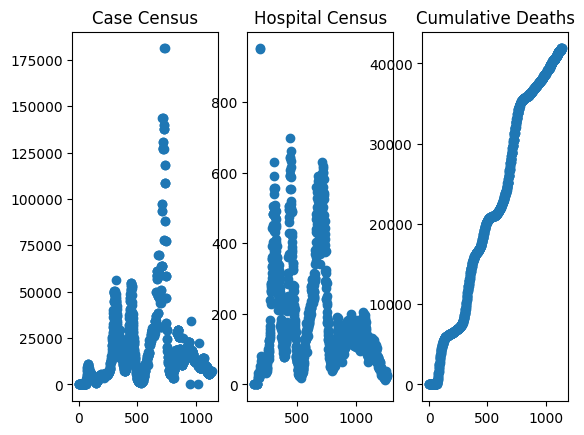

In [2]:
# Declare the region of interest and infectious period, get the DataFrame for that region
US_region = "MI" # 2-letter state abbreviation string (or "US")
total_population = 10050000 # Michigan: 10,050,000 / Louisiana: 4,624,000
infectious_period = 7 # duration of infectious period (in days)
plot_data = True # plot the data when true

# Note: source datasets are quite large, so this will take a minute to run
data = get_case_hosp_death_data(US_region = US_region, infectious_period = infectious_period, make_csv=False)
data = data.reset_index()
print(data)

# FYI: hosp data starts around 07/14/2020 and is NaN before, case and death data ends 03/04/2023 and is NaN after

if plot_data:
    # Plot case census data
    plt.subplot(1, 3, 1)
    plt.plot(data.index, data["case_census"], 'o')
    plt.title("Case Census")

    # Plot hosp census data
    plt.subplot(1, 3, 2)
    plt.plot(data.index, data["hosp_census"], 'o')
    plt.title("Hospital Census")

    # Plot cumulative deaths
    plt.subplot(1, 3, 3)
    plt.plot(data.index, data["cumulative_deaths"], 'o')
    plt.title("Cumulative Deaths")

### Set relevant dates, test and train intervals

In [3]:
# Set train start date at the first available datapoint to use all historic data available
train_start_date = str(data["date"][0]) # this is 01/22/2020

# Given timepoints will act as test start dates
timepoint1 = "2020-05-01" 
timepoint2 = "2021-05-01"
timepoint3 = "2021-12-15"

# Set test end dates 4 weeks after timepoints
test_end_date1 = "2020-05-29"
test_end_date2 = "2021-05-29"
test_end_date3 = "2022-01-12"

### Set up train and test data

In [4]:
# Gather train and test data corresponding to Timepoint 1
train_data1, train_cases1, train_timepoints1, test_cases1, test_timepoints1, all_timepoints1 = \
get_train_test_data(data, train_start_date, timepoint1, test_end_date1)

# Set the start time (for all simulations)
start_time = train_timepoints1[0] - 1e-5

# Gather train and test data corresponding to Timepoint 2
train_data2, train_cases2, train_timepoints2, test_cases2, test_timepoints2, all_timepoints2 = \
get_train_test_data(data, train_start_date, timepoint2, test_end_date2)

# Gather train and test data corresponding to Timepoint 3
train_data3, train_cases3, train_timepoints3, test_cases3, test_timepoints3, all_timepoints3 = \
get_train_test_data(data, train_start_date, timepoint3, test_end_date3)

## Models:
1. You may consider any of the models you have seen in the started kit, or 6-month hackathon and evaluation scenarios.

2. You may search for new models in the literature, or use TA2 model extension/transformation capabilities to modify models already in Terarium.

### Load dependencies for ensembling

In [5]:
# Load ensembling dependencies
import os
from pyciemss.PetriNetODE.interfaces import load_petri_model
from pyciemss.Ensemble.interfaces import load_and_sample_petri_ensemble, load_and_calibrate_and_sample_ensemble_model
from pyciemss.visuals import plots

ImportError: cannot import name 'plots' from 'pyciemss.visuals' (/Users/altu809/Projects/pyciemss/src/pyciemss/visuals/__init__.py)

### Get models to be ensembled

In [ ]:
FIRST_PATH = "../Examples_for_TA2_Model_Representation/"

# Model 1
filename1 = "SEIARHDS_AMR.json"
filename1 = os.path.join(FIRST_PATH, filename1)
# model1 = load_petri_model(filename1, add_uncertainty=True)

# Model 2
filename2 = "SEIARHD_AMR.json"
filename2 = os.path.join(FIRST_PATH, filename2)
# model2 = load_petri_model(filename2, add_uncertainty=True)

# Model 3
filename3 = "SIRHD_AMR.json"
filename3 = os.path.join(FIRST_PATH, filename3)
# model3 = load_petri_model(filename3, add_uncertainty=True)

model_paths = [filename1, filename2, filename3]

### Create functions to define solution mapping dictionaries

In [ ]:
# Define type of solution mapping required by each model
def solution_mapping1(model_solution: dict) -> dict:
    # solution mapping for model 1: SEIARHDS
    mapped_dict = {}
    mapped_dict["Cases"] = model_solution["symptomatic_population"] + model_solution["asymptomatic_population"]
    mapped_dict["Hospitalizations"] = model_solution["hospitalized_population"]
    mapped_dict["Deaths"] = model_solution["deceased_population"]
    return mapped_dict

def solution_mapping2(model_solution: dict) -> dict:
    # solution mapping for model 2: SEIARHD
    mapped_dict = {}
    mapped_dict["Cases"] = model_solution["symptomatic_population"] + model_solution["asymptomatic_population"]
    mapped_dict["Hospitalizations"] = model_solution["hospitalized_population"]
    mapped_dict["Deaths"] = model_solution["deceased_population"]
    return mapped_dict

def solution_mapping3(model_solution: dict) -> dict:
    # solution mapping for model 3: SIRHD
    mapped_dict = {}
    mapped_dict["Cases"] = model_solution["infectious_population"]
    mapped_dict["Hospitalizations"] = model_solution["hospitalized_population"]
    mapped_dict["Deaths"] = model_solution["deceased_population"]
    return mapped_dict

solution_mappings = [solution_mapping1, solution_mapping2, solution_mapping3]

### Create start states for each model at designated time points

In [ ]:
# Define start states for each model
def create_start_state1(data, t_0, total_population):
    '''Create the start state for Model 1 from data using our best guesses for
    mapping from observed variables to model state variables.'''
    
    start_state = data.set_index('date').loc[t_0].to_dict()
    returned_state["exposed_population"] = start_state['case_census'] / 2
    returned_state["symptomatic_population"] = start_state['case_census'] / 4
    returned_state["asymptomatic_population"] = 3 * start_state['case_census'] / 4
    returned_state["recovered_population"] = 2 * start_state['case_census']
    
    if start_state["hosp_census"] > 0:
        returned_state["hospitalized_population"] = start_state["hosp_census"]
    else:
        returned_state["hospitalized_population"] = 0
    
    returned_state["deceased_population"] = start_state["cumulative_deaths"]
    returned_state["susceptible_population"] = total_population - sum(returned_state.values())
    
    assert(returned_state["susceptible_population"] > 0)
    return {k:v/total_population for k, v in returned_state.items()}

def create_start_state2(data, t_0, total_population):
    '''Create the start state for Model 1 from data using our best guesses for
    mapping from observed variables to model state variables.'''
    
    start_state = data.set_index('date').loc[t_0].to_dict()
    returned_state["exposed_population"] = start_state['case_census'] / 2
    returned_state["symptomatic_population"] = start_state['case_census'] / 4
    returned_state["asymptomatic_population"] = 3 * start_state['case_census'] / 4
    returned_state["recovered_population"] = 2 * start_state['case_census']
    
    if start_state["hosp_census"] > 0:
        returned_state["hospitalized_population"] = start_state["hosp_census"]
    else:
        returned_state["hospitalized_population"] = 0
    
    returned_state["deceased_population"] = start_state["cumulative_deaths"]
    returned_state["susceptible_population"] = total_population - sum(returned_state.values())
    
    assert(returned_state["susceptible_population"] > 0)
    return {k:v/total_population for k, v in returned_state.items()}

def create_start_state3(data, t_0, total_population):
    '''Create the start state for Model 1 from data using our best guesses for
    mapping from observed variables to model state variables.'''
    
    start_state = data.set_index('date').loc[t_0].to_dict()
    returned_state["infectious_population"] = start_state['case_census']
    returned_state["recovered_population"] = 2 * start_state['case_census']
    
    if start_state["hosp_census"] > 0:
        returned_state["hospitalized_population"] = start_state["hosp_census"]
    else:
        returned_state["hospitalized_population"] = 0
    
    returned_state["deceased_population"] = start_state["cumulative_deaths"]
    returned_state["susceptible_population"] = total_population - sum(returned_state.values())
    
    assert(returned_state["susceptible_population"] > 0)
    return {k:v/total_population for k, v in returned_state.items()}

start_states = [create_start_state1(data, train_start_date, total_population), 
               create_start_state2(data, train_start_date, total_population), 
               create_start_state3(data, train_start_date, total_population)]

### Set up and calibrate the ensemble model to data

In [ ]:
DATA_PATH = "../hackathon_prep/"
data_filename = US_region + "_case_hosp_death_data.csv"
data_path = os.path.join(DATA_PATH, data_filename)
weights = [] # assume equal weights initially
for model in model_paths:
    weights.append(1/len(model_paths))
num_samples = 100
num_iterations = 100
test_timepoints = test_timepoints1

# Run the calibration and sampling
result = load_and_calibrate_and_sample_ensemble_model(
    model_paths,
    data_path,
    weights,
    solution_mappings,
    num_samples,
    test_timepoints,
    verbose=True,
    total_population,
    num_iterations,
    time_unit="days",
    visual_options={"title": "Calibrated Ensemble", "subset":".*_sol"}
)

# Save results
# result["data"].to_csv(
#     os.path.join(DEMO_PATH, "results_petri_ensemble/calibrated_sample_results.csv"), index=False
# )

plots.ipy_display(result["visual"])